# Unsupervised Representation Learning

You will explore how autoencoders can generate useful representations of data in an unsupervised manner. You will train autoencoders on the MNIST and Frey datasets, visualize what filters the network learns, and test the quality of the learned representation for data compression, generation, and classification.

Your implementation should use the Keras module in Tensorflow 2 (import tensorflow.keras).

# **Part 1: Frey face compression and generation**

## **1.1 Autoencoder setup and training**

Load the Frey dataset and convert the images to have `float32` type and a range of `[-1 1]`. Display some of the images.

Set up an autoencoder, following the example in the linear autoencoder notebook. Unlike the linear autoencoder, your autoencoder should use a multi-layer perceptron for the encoder and decoder and have a two-dimensional latent space. The hidden layers in your encoder and decoder should have some non-linear activation such as ReLU or Leaky ReLU, except the embedding or bottleneck layer (last layer of encoder) which should have a tanh activation. The last layer of the decoder should have size `28*20` and should have linear (None) activation.

The exact design of the encoder and decoder is up to you. For reference, I used a two-layer MLP for the encoder and decoder, and the number of channels was `64-32-2-32-64`.

In [1]:
import numpy as np
import matplotlib as mpl
mpl.rc('image', cmap='gray')
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Flatten, Dense, Reshape, LeakyReLU, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import get_file
from scipy.io import loadmat

### Data Loading and Pre-processing

In [2]:
path = get_file('frey_rawface.mat','https://www.dropbox.com/scl/fi/m70sh4ef39pvy01czc63r/frey_rawface.mat?rlkey=5v6meiap55z68ada2roxwxuql&dl=1')
data = np.transpose(loadmat(path)['ff'])
# reshape to (num_images, height, width)
images = np.reshape(data,(-1,28,20))

np.random.seed(1234)
np.random.shuffle(images)

print(f"Dataset shape: {images.shape}")
print(f"Pixel value range before scaling: [{np.min(images)}, {np.max(images)}]")

Dataset shape: (1965, 28, 20)
Pixel value range before scaling: [8, 238]


Sample images from the dataset:


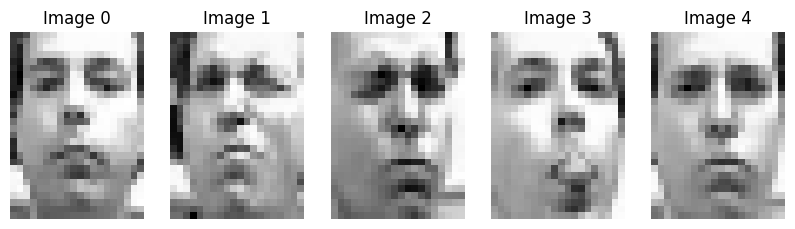

In [3]:
# display some images
print("Sample images from the dataset:")
plt.figure(figsize=(10, 4))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(images[i])
    plt.title(f"Image {i}")
    plt.axis('off')
plt.show()

In [4]:
# split data and preprocess
# using the same split ratio as the reference notebook
split_idx = 1800
x_train_orig = images[0:split_idx]
x_test_orig = images[split_idx:]

# convert to float32 and scale to [-1, 1]
x_train = (x_train_orig.astype('float32') / 255.0) * 2.0 - 1.0
x_test = (x_test_orig.astype('float32') / 255.0) * 2.0 - 1.0

img_height, img_width = x_train.shape[1], x_train.shape[2]
img_shape = (img_height, img_width)
flat_img_size = img_height * img_width

print(f"\nTraining data shape: {x_train.shape}")
print(f"Testing data shape: {x_test.shape}")
print(f"Pixel value range after scaling: [{np.min(x_train)}, {np.max(x_train)}]")
print(f"Image shape: {img_shape}")
print(f"Flattened image size: {flat_img_size}")


Training data shape: (1800, 28, 20)
Testing data shape: (165, 28, 20)
Pixel value range after scaling: [-0.9372549057006836, 0.8666666746139526]
Image shape: (28, 20)
Flattened image size: 560


### Building the MLP Autoencoder

In [5]:
# define latent dimension
latent_dim = 2

# define activation for hidden layers
# activation_fn = 'relu'
# using LeakyReLU as suggested alternative
activation_fn = LeakyReLU(alpha=0.2)

# using the suggested architecture 64-32-2-32-64
def build_mlp_encoder(latent_dim, img_shape):
    inputs = Input(shape=img_shape, name='encoder_input')
    flat = Flatten()(inputs)
    x = Dense(64)(flat)
    x = activation_fn(x)
    x = Dense(32)(x)
    x = activation_fn(x)
    # bottleneck layer with tanh activation
    embedding = Dense(latent_dim, activation='tanh', name='encoder_embedding')(x)
    return Model(inputs=inputs, outputs=embedding, name='encoder')

def build_mlp_decoder(latent_dim, flat_img_size, img_shape):
    inputs = Input(shape=(latent_dim,), name='decoder_input')
    x = Dense(32)(inputs)
    x = activation_fn(x)
    x = Dense(64)(x)
    x = activation_fn(x)
    # output layer with linear activation
    reconstruction_flat = Dense(flat_img_size, activation=None, name='decoder_output_flat')(x)
    # reshape back to image dimensions
    reshaped = Reshape(img_shape, name='decoder_output_reshaped')(reconstruction_flat)
    return Model(inputs=inputs, outputs=reshaped, name='decoder')

def build_mlp_autoencoder(encoder, decoder, img_shape):
    inputs = Input(shape=img_shape, name='autoencoder_input')
    embedding = encoder(inputs)
    reconstruction = decoder(embedding)
    return Model(inputs=inputs, outputs=reconstruction, name='autoencoder')

encoder_mlp = build_mlp_encoder(latent_dim, img_shape)
decoder_mlp = build_mlp_decoder(latent_dim, flat_img_size, img_shape)
autoencoder_mlp = build_mlp_autoencoder(encoder_mlp, decoder_mlp, img_shape)

print("Encoder Summary:")
encoder_mlp.summary()
print("\nDecoder Summary:")
decoder_mlp.summary()
print("\nAutoencoder Summary:")
autoencoder_mlp.summary()

Encoder Summary:


/Users/bshowell/Desktop/school/spring 24-25/587/.venv/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 28, 20)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 560)       │          0 │ encoder_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │     35,904 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 64)        │          0 │ dense[0][0],      │
│ (LeakyReLU)         │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │      2,080 │ leaky_re_lu[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_embedding   │ (None, 2)         │         66 │ leaky_re_lu[1][0] │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,050 (148.63 KB)

 Trainable params: 38,050 (148.63 KB)

 Non-trainable params: 0 (0.00 B)


Decoder Summary:


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ decoder_input       │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │         96 │ decoder_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 64)        │          0 │ dense_2[0][0],    │
│ (LeakyReLU)         │                   │            │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │      2,112 │ leaky_re_lu[2][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_output_flat │ (None, 560)       │     36,400 │ leaky_re_lu[3][0] │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_output_res… │ (None, 28, 20)    │          0 │ decoder_output_f… │
│ (Reshape)           │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,608 (150.81 KB)

 Trainable params: 38,608 (150.81 KB)

 Non-trainable params: 0 (0.00 B)


Autoencoder Summary:


Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ autoencoder_input (InputLayer)  │ (None, 28, 20)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 2)              │        38,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 28, 20)         │        38,608 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 76,658 (299.45 KB)

 Trainable params: 76,658 (299.45 KB)

 Non-trainable params: 0 (0.00 B)

### Compiling and Training the Autoencoder

In [6]:
opt = Adam(learning_rate=3e-4)
autoencoder_mlp.compile(optimizer=opt, loss='mean_squared_error')

# train the autoencoder
batch_size = 64
epochs = 300

print("\nTraining MLP Autoencoder...")
history_mlp = autoencoder_mlp.fit(x_train, x_train,
                                  batch_size=batch_size,
                                  epochs=epochs,
                                  verbose=0,
                                  validation_split=0.1)
print("Training complete.")


Training MLP Autoencoder...
Training complete.


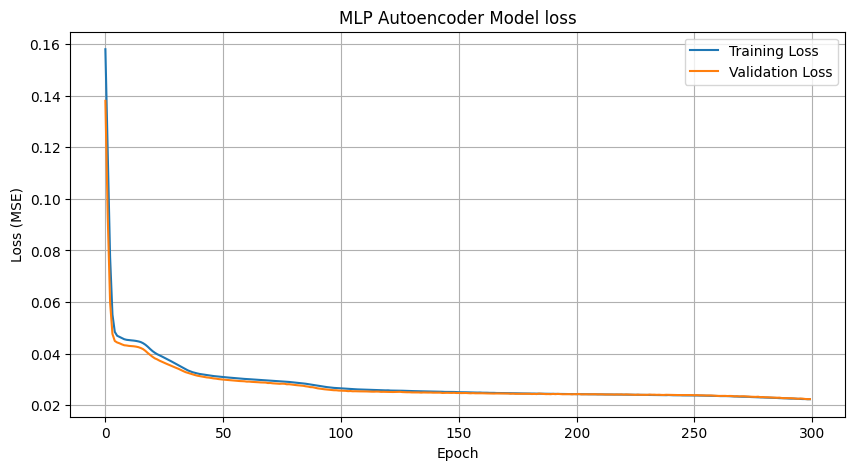

In [7]:
plt.figure(figsize=(10, 5))
plt.plot(history_mlp.history['loss'], label='Training Loss')
plt.plot(history_mlp.history['val_loss'], label='Validation Loss')
plt.title('MLP Autoencoder Model loss')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

## **1.2 Analysis and Visualization**

### Image Reconstruction

Test the ability of the autoencoder to compress and decompress the images. Compare some input images to their reconstructions after running the autoencoder.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


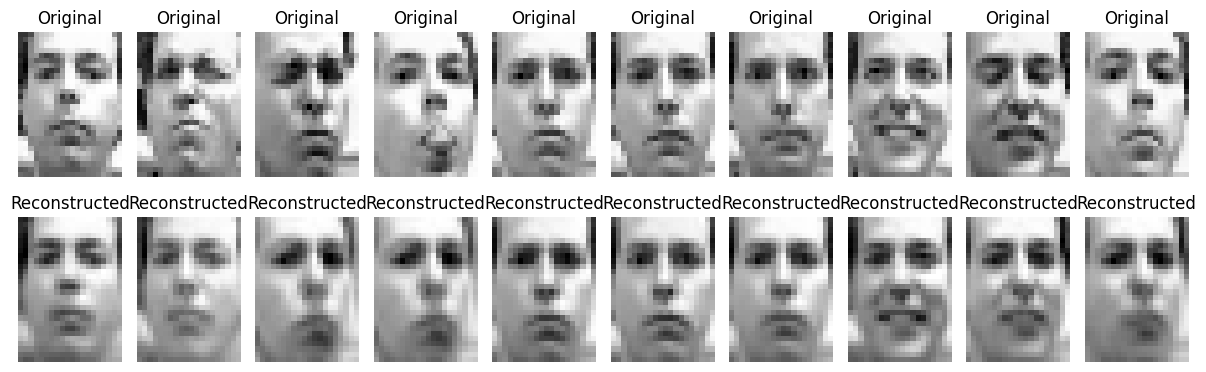

In [8]:
# get reconstructions for a few training images
n_display = 10
reconstructions = autoencoder_mlp.predict(x_train[:n_display])

plt.figure(figsize=(12, 4))
for i in range(n_display):
    # display original images (scaled back to [0, 1] for imshow)
    ax = plt.subplot(2, n_display, i + 1)
    plt.imshow((x_train[i] + 1.0) / 2.0)
    plt.title("Original")
    plt.axis('off')

    ax = plt.subplot(2, n_display, i + 1 + n_display)
    plt.imshow((reconstructions[i] + 1.0) / 2.0)
    plt.title("Reconstructed")
    plt.axis('off')
plt.tight_layout()
plt.show()

The reconstructions capture the general pose and expression quite well, but they appear a lot blurrier than the originals, losing fine details. But this is expected because of the extreme compression into a 2D latent space.
Compared to a linear autoencoder with a small latent space (like 2D that we've been doing), the non-linear version might produce slightly more plausible but still blurry faces, which is able to handle variations in expression or pose in a more structured way comparatively. The linear version, however, produced overall sharper results than this non-linear version.

### Latent Space Visualization

Visualize the output of the encoder (run on the training data) as a scatter plot.

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step
Shape of latent vectors: (1800, 2)


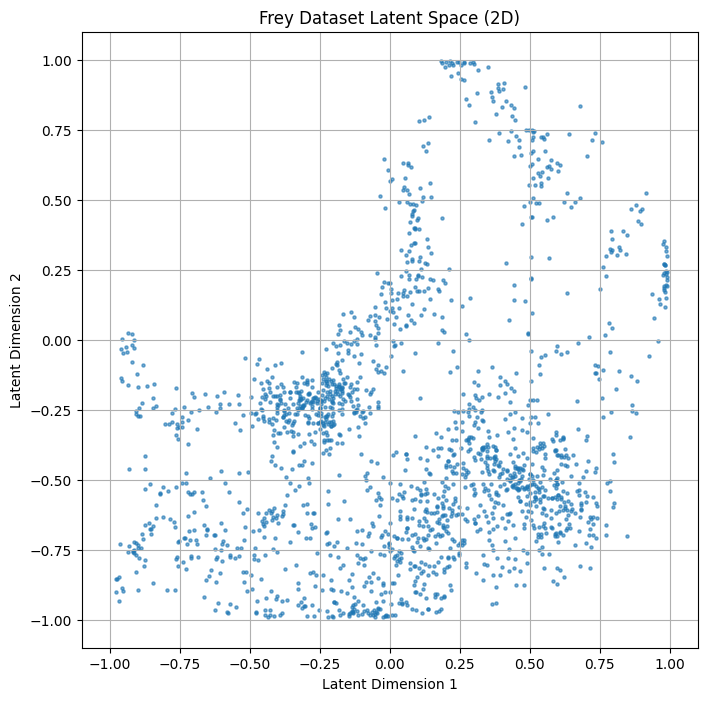

In [9]:
# encode the training data to get latent vectors
latent_vectors_train = encoder_mlp.predict(x_train)

print(f"Shape of latent vectors: {latent_vectors_train.shape}")

plt.figure(figsize=(8, 8))
plt.scatter(latent_vectors_train[:, 0], latent_vectors_train[:, 1], s=5, alpha=0.6)
plt.title('Frey Dataset Latent Space (2D)')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.xlim([-1.1, 1.1])
plt.ylim([-1.1, 1.1])
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

**Observations:**
The points seem to form a specific, double curvedish shape cluster within the 2D space, showing how the autoencoder learned to map the high-dimensional face variations into a lower-dimensional space. There are denser areas, which probably correspond to common poses/expressions.
The points are all confined within the space but the points are not evenly spread. There is a large gap in the upper left quadrant that is empty of points, suggesting that that area did not get used in the mapping.

### Generating New Faces from Latent Space Grid

Generate new faces by decoding a set of embedding points on `[-1 1] x [-1 1]` grid.

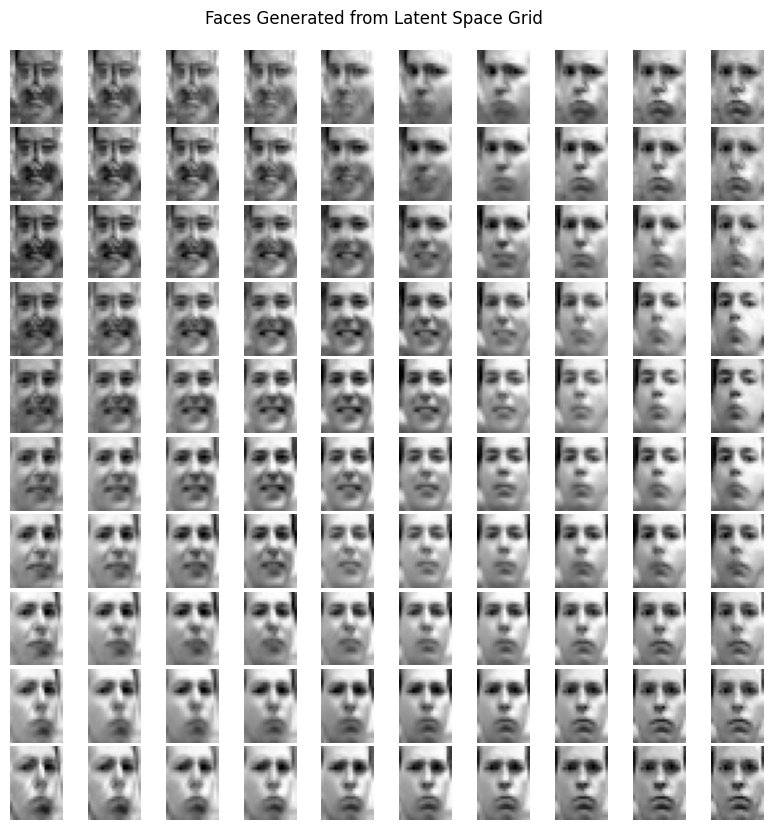

In [12]:
n_points = 10 # create 10x10 grid
grid_x = np.linspace(-1.0, 1.0, n_points)
grid_y = np.linspace(1.0, -1.0, n_points)

plt.figure(figsize=(10, 10))
for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        # create latent vector for this grid point
        latent_vector = np.array([[xi, yi]])
        # decode
        generated_image = decoder_mlp.predict(latent_vector, verbose=0)
        # display the generated image
        ax = plt.subplot(n_points, n_points, i * n_points + j + 1)
        plt.imshow((generated_image[0] + 1.0) / 2.0)
        plt.axis('off')

plt.suptitle("Faces Generated from Latent Space Grid", y=0.92)
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()

The generated images show gradual transitions across the grid, changing pose (left-right looking) primarily along the x axis and expression moreso along the y axis, although this isn't exact at all. For example, The smiling expression seems to generally live in the middle-left area in the 2d space.
Faces generated from the areas outside the main data distribution (seen in the scatter plot) look very distorted. For example, the entire upper left quadrant, which as seen from the scatterplot above, has no points that map there, are all distorted and distinctly un-face-like.

### Interpolation Between Faces

Test interpolation between two images.

In [13]:
def interpolate_between_mlp(imgA_index, imgB_index, num_steps=10):
    plt.figure(figsize=(12, 3))

    imgA = x_test[imgA_index]
    imgB = x_test[imgB_index]

    imgA_encoded = encoder_mlp.predict(x_test[imgA_index:(imgA_index+1)])
    imgB_encoded = encoder_mlp.predict(x_test[imgB_index:(imgB_index+1)])

    print(f"Image A ({imgA_index}) encoding: {imgA_encoded}")
    print(f"Image B ({imgB_index}) encoding: {imgB_encoded}")

    alphas = np.linspace(0, 1, num=num_steps)
    for n, alpha in enumerate(alphas):
        # interpolate in latent space
        img_encoded = (1 - alpha) * imgA_encoded + alpha * imgB_encoded
        # decode the interpolated latent vector
        img_decoded = decoder_mlp.predict(img_encoded, verbose=0)

        # display the interpolated image (scaled back to [0, 1])
        ax = plt.subplot(1, num_steps, n + 1)
        plt.imshow((np.squeeze(img_decoded) + 1.0) / 2.0)
        plt.title(f"$\\alpha={alpha:.2f}$")
        plt.axis('off')
    plt.suptitle(f"Interpolation between Test Image {imgA_index} and {imgB_index}", y=1.02)
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Image A (0) encoding: [[-0.17391585 -0.7568977 ]]
Image B (1) encoding: [[ 0.03400124 -0.8826001 ]]


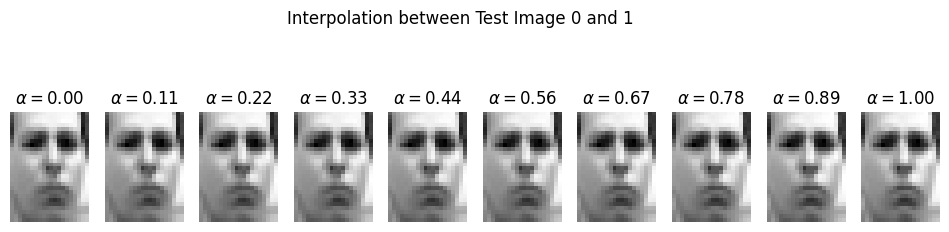

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Image A (2) encoding: [[-0.35129598 -0.23541437]]
Image B (3) encoding: [[-0.04651837 -0.04395724]]


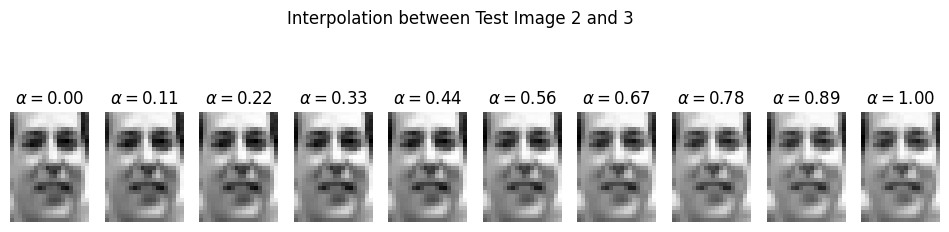

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Image A (0) encoding: [[-0.17391585 -0.7568977 ]]
Image B (4) encoding: [[-0.05698666 -0.9192494 ]]


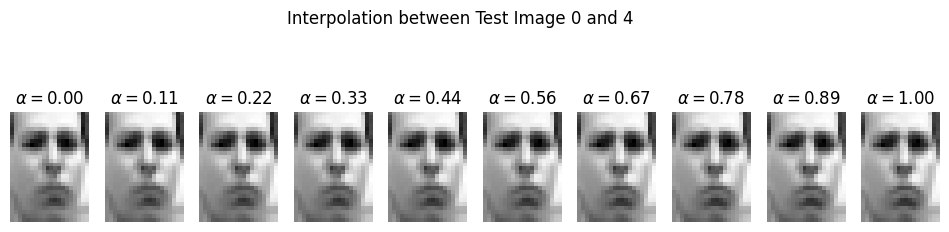

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Image A (-2) encoding: [[-0.32184973 -0.18038742]]
Image B (4) encoding: [[-0.05698666 -0.9192494 ]]


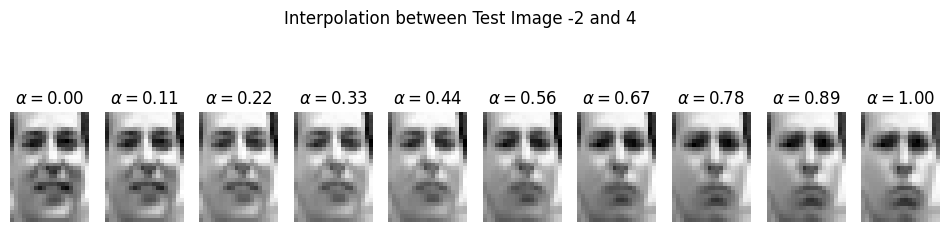

In [16]:
interpolate_between_mlp(0, 1)
interpolate_between_mlp(2, 3)
interpolate_between_mlp(0, 4)
interpolate_between_mlp(-2, 4)

Overall, it produces smooth transitions between the start and end faces. The intermediate images look like very plausible faces, capturing changes in pose and expression more naturally than other techniques you could try like pixel averaging. However, probably due to the 2D bottleneck, the images remain blurry. Compared to the 32D linear autoencoder interpolation (which was also quite good), this 2D non-linear interpolation might show more significant changes in features across the steps, as it compresses information more drastically, but the overall image fidelity seems to be lower.

# **Part II: MNIST digit classification with unsupervised pre-training**

Set up and train a similar MLP autoencoder on the MNIST dataset. Use only digits 0 and 1 to make the task a little easier. Use mean squared error loss for this dataset--I found it to work more reliably than mean absolute error.

After training the autoencoder, obtain the embedding vectors of all training and testing images.

Then, create and train another network that will classify the embedding vectors produced by your encoder. Train the network on the training data and test it (model.evaluate()) on the testing data. What test accuracy are you able to achieve? Discuss the effectiveness of unsupervised pre-training in this experiment.

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Flatten, Dense, Reshape, LeakyReLU, Activation, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam

### MNIST Data Loading and Preprocessing (Digits 0 and 1 only)

In [18]:
(x_train_mnist, y_train_mnist), (x_test_mnist, y_test_mnist) = mnist.load_data()

# filter for digits 0 and 1
train_mask = np.isin(y_train_mnist, [0, 1])
test_mask = np.isin(y_test_mnist, [0, 1])

x_train_01 = x_train_mnist[train_mask]
y_train_01 = y_train_mnist[train_mask]
x_test_01 = x_test_mnist[test_mask]
y_test_01 = y_test_mnist[test_mask]

print(f"Original MNIST train shape: {x_train_mnist.shape}")
print(f"Filtered MNIST train shape (0s and 1s): {x_train_01.shape}")
print(f"Original MNIST test shape: {x_test_mnist.shape}")
print(f"Filtered MNIST test shape (0s and 1s): {x_test_01.shape}")

Original MNIST train shape: (60000, 28, 28)
Filtered MNIST train shape (0s and 1s): (12665, 28, 28)
Original MNIST test shape: (10000, 28, 28)
Filtered MNIST test shape (0s and 1s): (2115, 28, 28)


Sample MNIST images (Digits 0 and 1):


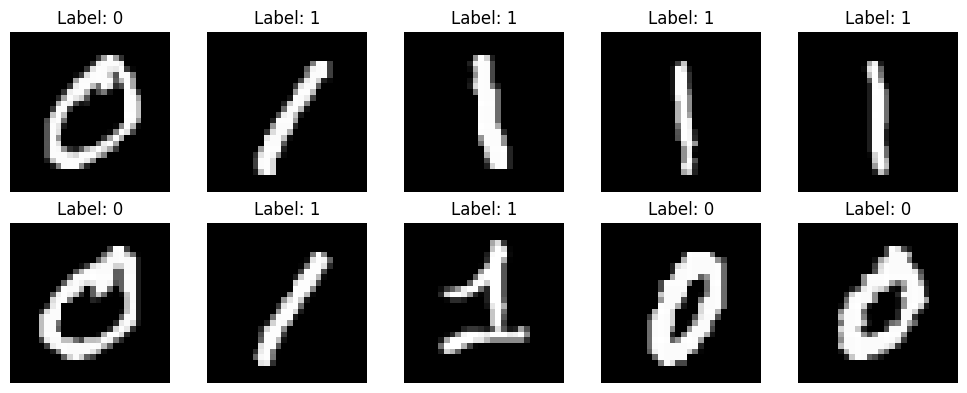

In [19]:
# display some filtered images
print("Sample MNIST images (Digits 0 and 1):")
plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(x_train_01[i], cmap='gray')
    plt.title(f"Label: {y_train_01[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [20]:
# preprocess the data
x_train_01 = (x_train_01.astype('float32') / 255.0) * 2.0 - 1.0
x_test_01 = (x_test_01.astype('float32') / 255.0) * 2.0 - 1.0

mnist_img_height, mnist_img_width = x_train_01.shape[1], x_train_01.shape[2]
mnist_img_shape = (mnist_img_height, mnist_img_width)
mnist_flat_img_size = mnist_img_height * mnist_img_width

print(f"\nMNIST Image shape: {mnist_img_shape}")
print(f"Flattened MNIST image size: {mnist_flat_img_size}")
print(f"Pixel value range after scaling: [{np.min(x_train_01)}, {np.max(x_train_01)}]")


MNIST Image shape: (28, 28)
Flattened MNIST image size: 784
Pixel value range after scaling: [-1.0, 1.0]


### Building and Training the MNIST Autoencoder

In [21]:
mnist_latent_dim = 16
mnist_activation_fn = LeakyReLU(alpha=0.2)

def build_mnist_encoder(latent_dim, img_shape):
  inputs = Input(shape=img_shape, name='encoder_input')
  flat = Flatten()(inputs)
  x = Dense(128)(flat)
  x = mnist_activation_fn(x)
  x = Dense(64)(x)
  x = mnist_activation_fn(x)
  # bottleneck layer with tanh activation
  embedding = Dense(latent_dim, activation='tanh', name='encoder_embedding')(x)
  return Model(inputs=inputs, outputs=embedding, name='mnist_encoder')

def build_mnist_decoder(latent_dim, flat_img_size, img_shape):
  inputs = Input(shape=(latent_dim,), name='decoder_input')
  x = Dense(64)(inputs)
  x = mnist_activation_fn(x)
  x = Dense(128)(x)
  x = mnist_activation_fn(x)
  # output layer with linear activation
  reconstruction_flat = Dense(flat_img_size, activation=None, name='decoder_output_flat')(x)
  # reshape back to image dimensions
  reshaped = Reshape(img_shape, name='decoder_output_reshaped')(reconstruction_flat)
  return Model(inputs=inputs, outputs=reshaped, name='mnist_decoder')

def build_mnist_autoencoder(encoder, decoder, img_shape):
  inputs = Input(shape=img_shape, name='autoencoder_input')
  embedding = encoder(inputs)
  reconstruction = decoder(embedding)
  return Model(inputs=inputs, outputs=reconstruction, name='mnist_autoencoder')

mnist_encoder = build_mnist_encoder(mnist_latent_dim, mnist_img_shape)
mnist_decoder = build_mnist_decoder(mnist_latent_dim, mnist_flat_img_size, mnist_img_shape)
mnist_autoencoder = build_mnist_autoencoder(mnist_encoder, mnist_decoder, mnist_img_shape)

print("MNIST Encoder Summary:")
mnist_encoder.summary()
print("\nMNIST Decoder Summary:")
mnist_decoder.summary()
print("\nMNIST Autoencoder Summary:")
mnist_autoencoder.summary()

MNIST Encoder Summary:


Model: "mnist_encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 28, 28)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 784)       │          0 │ encoder_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │    100,480 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 128)       │          0 │ dense_4[0][0],    │
│ (LeakyReLU)         │                   │            │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 64)        │      8,256 │ leaky_re_lu_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_embedding   │ (None, 16)        │      1,040 │ leaky_re_lu_1[1]… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 109,776 (428.81 KB)

 Trainable params: 109,776 (428.81 KB)

 Non-trainable params: 0 (0.00 B)


MNIST Decoder Summary:


Model: "mnist_decoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ decoder_input       │ (None, 16)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 64)        │      1,088 │ decoder_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 128)       │          0 │ dense_6[0][0],    │
│ (LeakyReLU)         │                   │            │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 128)       │      8,320 │ leaky_re_lu_1[2]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_output_flat │ (None, 784)       │    101,136 │ leaky_re_lu_1[3]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_output_res… │ (None, 28, 28)    │          0 │ decoder_output_f… │
│ (Reshape)           │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 110,544 (431.81 KB)

 Trainable params: 110,544 (431.81 KB)

 Non-trainable params: 0 (0.00 B)


MNIST Autoencoder Summary:


Model: "mnist_autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ autoencoder_input (InputLayer)  │ (None, 28, 28)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mnist_encoder (Functional)      │ (None, 16)             │       109,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mnist_decoder (Functional)      │ (None, 28, 28)         │       110,544 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 220,320 (860.62 KB)

 Trainable params: 220,320 (860.62 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
mnist_opt = Adam(learning_rate=3e-4)
mnist_autoencoder.compile(optimizer=mnist_opt, loss='mean_squared_error')

# Train the MNIST autoencoder
mnist_batch_size = 128
mnist_epochs = 50

print("\nTraining MNIST Autoencoder (Digits 0 & 1)...")
history_mnist_ae = mnist_autoencoder.fit(x_train_01, x_train_01,
                                         batch_size=mnist_batch_size,
                                         epochs=mnist_epochs,
                                         verbose=0,
                                         validation_data=(x_test_01, x_test_01))
print("Training complete.")


Training MNIST Autoencoder (Digits 0 & 1)...
Training complete.


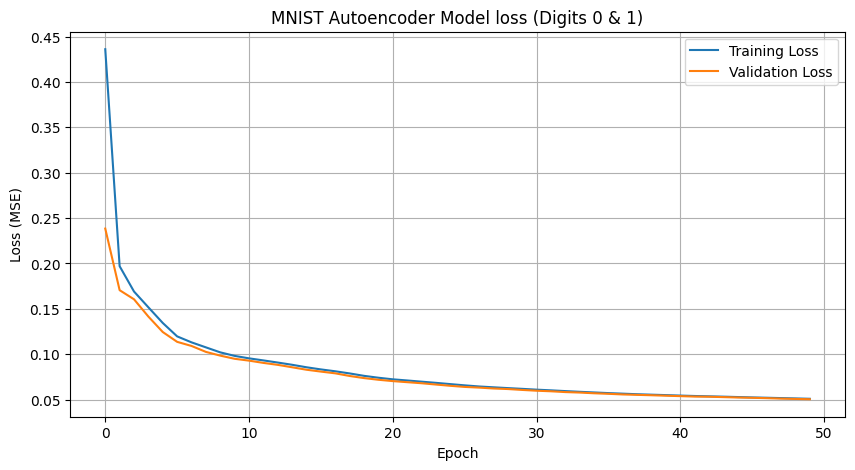

In [23]:
# plot training & validation loss values for MNIST AE
plt.figure(figsize=(10, 5))
plt.plot(history_mnist_ae.history['loss'], label='Training Loss')
plt.plot(history_mnist_ae.history['val_loss'], label='Validation Loss')
plt.title('MNIST Autoencoder Model loss (Digits 0 & 1)')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


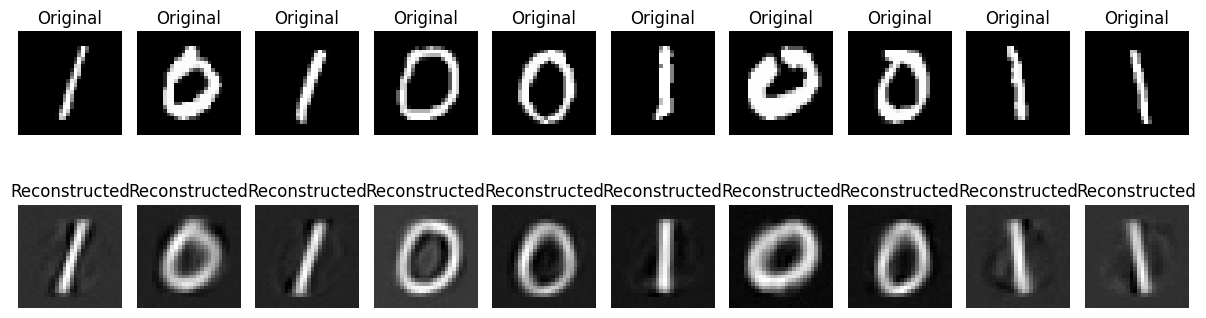

In [24]:
# visualize some reconstructions for MNIST 0s and 1s
n_display_mnist = 10
mnist_reconstructions = mnist_autoencoder.predict(x_test_01[:n_display_mnist])

plt.figure(figsize=(12, 4))
for i in range(n_display_mnist):
    ax = plt.subplot(2, n_display_mnist, i + 1)
    plt.imshow((x_test_01[i] + 1.0) / 2.0, cmap='gray')
    plt.title("Original")
    plt.axis('off')

    ax = plt.subplot(2, n_display_mnist, i + 1 + n_display_mnist)
    plt.imshow((mnist_reconstructions[i] + 1.0) / 2.0, cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')
plt.tight_layout()
plt.show()

### Generating Embeddings

In [25]:
print("Generating embeddings for training and testing data...")
train_embeddings = mnist_encoder.predict(x_train_01)
test_embeddings = mnist_encoder.predict(x_test_01)

print(f"Shape of training embeddings: {train_embeddings.shape}")
print(f"Shape of testing embeddings: {test_embeddings.shape}")

Generating embeddings for training and testing data...
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step
Shape of training embeddings: (12665, 16)
Shape of testing embeddings: (2115, 16)


### Building and Training the Classifier on Embeddings

In [26]:
classifier = Sequential([
    Input(shape=(mnist_latent_dim,), name='classifier_input'),
    Dense(32, activation='relu'), # small hidden layer
    Dropout(0.5), # dropout for regularization
    Dense(1, activation='sigmoid', name='classifier_output') # binary classification
], name='embedding_classifier')

print("\nClassifier Summary:")
classifier.summary()


Classifier Summary:


Model: "embedding_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier_output (Dense)       │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 577 (2.25 KB)

 Trainable params: 577 (2.25 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
classifier.compile(optimizer=Adam(learning_rate=1e-3),
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

classifier_batch_size = 64
classifier_epochs = 50

print("\nTraining Classifier on Embeddings...")
history_classifier = classifier.fit(train_embeddings, y_train_01,
                                    batch_size=classifier_batch_size,
                                    epochs=classifier_epochs,
                                    verbose=0,
                                    validation_data=(test_embeddings, y_test_01))
print("Classifier training complete.")


Training Classifier on Embeddings...
Classifier training complete.


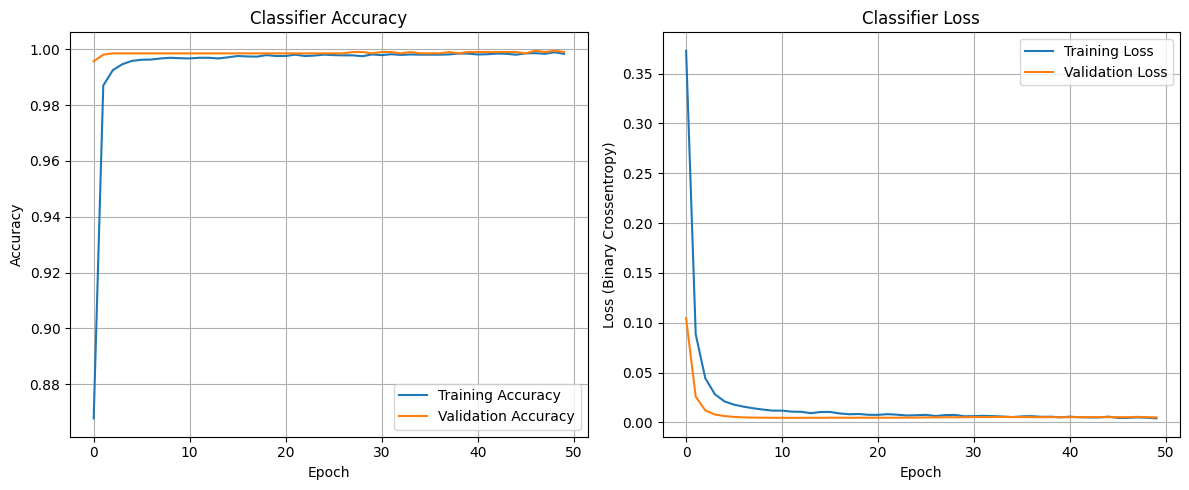

In [28]:
# plot training & validation accuracy and loss for the classifier
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_classifier.history['accuracy'], label='Training Accuracy')
plt.plot(history_classifier.history['val_accuracy'], label='Validation Accuracy')
plt.title('Classifier Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_classifier.history['loss'], label='Training Loss')
plt.plot(history_classifier.history['val_loss'], label='Validation Loss')
plt.title('Classifier Loss')
plt.ylabel('Loss (Binary Crossentropy)')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()

### Evaluating the Classifier

In [29]:
loss, accuracy = classifier.evaluate(test_embeddings, y_test_01, verbose=0)
print(f"\nClassifier Test Loss: {loss:.4f}")
print(f"Classifier Test Accuracy: {accuracy:.4f}")


Classifier Test Loss: 0.0050
Classifier Test Accuracy: 0.9991


The classifier achieved a test accuracy of 99.91%
The high test accuracy achieved demonstrates that the unsupervised autoencoder learned a compressed representation (latent space) that very well was able to capture the distinguishing features between digits 0 and 1, even though it wasn't explicitly trained for classification. This shows the power of unsupervised pre-training for dimensionality reduction and feature extraction. Training a classifier on these low-dimensional embeddings is much more computationally efficient and can yield really good results, suggesting the learned features are very relevant. It's possible a classifier trained directly on pixels might achieve slightly higher accuracy, but it would operate on much higher dimensional data so with this high of an accuracy, that would be pointless to do.